In [1]:
import math as math
# Load libraries
import random
from itertools import batched
import sympy as sp

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fontTools.misc.timeTools import epoch_diff

In [2]:
# Read data
data = np.loadtxt('data/ex2data1.txt', delimiter=',')
np.random.shuffle(data)
X = data[:, :-1]
Y = data[:, -1, np.newaxis]
print(X.shape, Y.shape)
print(data)

(100, 2) (100, 1)
[[44.66826172 66.45008615  0.        ]
 [80.19018075 44.82162893  1.        ]
 [67.31925747 66.58935318  1.        ]
 [50.53478829 48.85581153  0.        ]
 [54.63510555 52.21388588  0.        ]
 [34.21206098 44.2095286   0.        ]
 [99.31500881 68.77540947  1.        ]
 [64.17698887 80.90806059  1.        ]
 [84.43281996 43.53339331  1.        ]
 [77.19303493 70.4582      1.        ]
 [40.23689374 71.16774802  0.        ]
 [99.27252693 60.999031    1.        ]
 [62.22267576 52.06099195  0.        ]
 [88.91389642 69.8037889   1.        ]
 [60.45788574 73.0949981   1.        ]
 [80.27957401 92.11606081  1.        ]
 [30.05882245 49.59297387  0.        ]
 [62.0730638  96.76882412  1.        ]
 [35.28611282 47.02051395  0.        ]
 [75.39561147 85.75993667  1.        ]
 [94.44336777 65.56892161  1.        ]
 [78.63542435 96.64742717  1.        ]
 [50.4581598  75.80985953  1.        ]
 [72.34649423 96.22759297  1.        ]
 [56.2538175  39.26147251  0.        ]
 [75.01

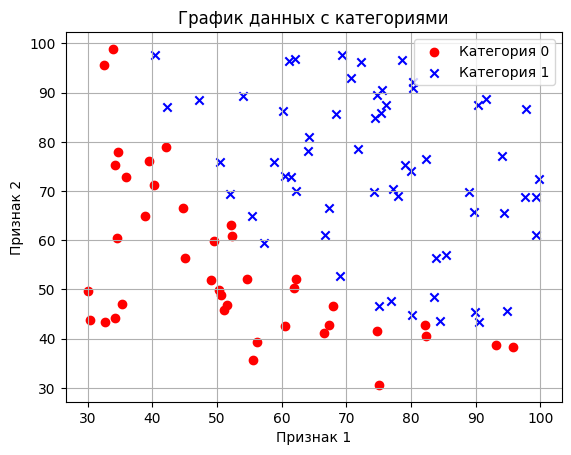

In [3]:
def plot_data(data):
    x1 = data[:, 0]
    x2 = data[:, 1]
    y = data[:, 2]

    #plt.figure(figsize=(8,6))
    plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Категория 0', marker='o')
    plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Категория 1', marker='x')

    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('График данных с категориями')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_data(data)



In [4]:
# Standardize data
def standardize_data(data, means = None, stds = None):
    calc_means = means
    calc_stds = stds
    if means is None and stds is None:
        calc_means = np.mean(data, axis=0)
        calc_stds = np.std(data, axis=0)
    return (data - calc_means) / calc_stds, calc_means, calc_stds

X_standard, means, stds = standardize_data(X)

In [5]:
# Split data
def split_data(x_data, y_data):
    train_size = int(x_data.shape[0] * 0.5)
    x_train, x_validate = x_data[:train_size], x_data[train_size:]
    y_train, y_validate = y_data[:train_size], y_data[train_size:]
    return x_train, y_train, x_validate, y_validate

def prepare_data(X, Y):
    X_train, y_train, X_validate, y_validate = split_data(X, Y)
    X_train, means, stds = standardize_data(X_train)
    X_validate = standardize_data(X_validate, means, stds)[0]
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_validate = np.hstack((np.ones((X_validate.shape[0], 1)), X_validate))
    return X_train, y_train, X_validate, y_validate, means, stds


In [6]:
def draw_errors(train_error_array, validate_error_array, alpha):
    epochs = np.arange(1, len(train_error_array) + 1)

    # Линия для train_error (сплошная линия)
    plt.plot(epochs, train_error_array, label='Train Error', color='blue', linewidth=2)

    # Линия для validate_error (пунктирная линия)
    plt.plot(epochs, validate_error_array, label='Validation Error', color='red', linewidth=2)

    # Настройка графика
    plt.title(f'График ошибки с коэффициентом обучения {round(alpha, 8)}')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()

    # Отображение графика
    plt.grid(True)
    plt.show()


def plot_data_with_function(data, teta, line_function):
    x1 = data[:, 0]
    x2 = data[:, 1]
    y = data[:, 2]

    try:
        x1S, x2S, expr = line_function(teta)
        x1_vals = np.linspace(min(x1), max(x1), 100)
        x1_vals_std = (x1_vals - means[0]) / stds[0]
        x2_vals_std = np.array([float(expr[0].subs(x1S, x_val)) for x_val in x1_vals_std])
        x2_vals = x2_vals_std * stds[1] + means[1]
        plt.plot(x1_vals, x2_vals, color='green', label='Линейная функция')
        print(expr[0].subs(x1S, 0))
    except:
        print("Не получилось построить график функции")
        return

    #plt.figure(figsize=(8,6))
    plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Категория 0', marker='o')
    plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Категория 1', marker='x')


    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('График данных с категориями')
    plt.legend()
    plt.grid(True)
    plt.show()


def calculate_h(teta, x_matrix):
    v = x_matrix @ (teta.T)
    sigmoid = 1 / (1 + (math.e ** (-v)))
    return sigmoid


def calculate_teta_shift(h_array, x_matrix, y_array, spead: float):
    return spead * ((h_array - y_array).T @ x_matrix) / x_matrix.shape[0]


def calculate_error(x_matrix, y_array, teta):
    #return ((y_array - calculate_h(teta, x_matrix)) ** 2).sum() / x_matrix.shape[0]
    h = calculate_h(teta, x_matrix)
    one_column = np.ones((x_matrix.shape[0], 1))
    j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)
    return j.sum() / x_matrix.shape[0]


def learn_model(x_train_matrix, y_train_array, x_validate_matrix, y_validate_array, start_teta, epoch, learn,
                batch_size):
    teta = start_teta.copy()
    train_error_array = []
    validate_error_array = []
    data_size = x_train_matrix.shape[0]
    for i in range(epoch):
        # shuffled data
        shuffled_indices = np.random.permutation(data_size)
        x_matrix_shuffled = x_train_matrix[shuffled_indices]
        y_array_shuffled = y_train_array[shuffled_indices]

        # calculate teta shift by minibatch
        for start_batch_index in range(0, data_size, batch_size):
            x_batch = x_matrix_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            y_batch = y_array_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            h_array = calculate_h(teta, x_batch)
            teta = teta - calculate_teta_shift(h_array, x_batch, y_batch, learn)

        train_error = calculate_error(x_train_matrix, y_train_array, teta)
        validate_error = calculate_error(x_validate_matrix, y_validate_array, teta)
        #print("train error: ", train_error, " validation error: ", validate_error)
        train_error_array.append(train_error)
        validate_error_array.append(validate_error)

    return teta, train_error_array, validate_error_array


def learn_model_with_any_superparameters(x_train, y_train, x_validate, y_validated, line_function):
    epoch_values = np.linspace(500, 5000, 3)
    learn_coefficients = np.linspace(0.01, 0.001, 2)
    # epoch_values = [400]
    # learn_coefficients = [0.01]
    for epoch in epoch_values:
        for learn_cof in learn_coefficients:
            start_teta = (np.random.randint(-12, 12, size=X_train.shape[1]))[np.newaxis, :]
            teta, train_error, validate_error = learn_model(x_train, y_train, x_validate, y_validated, start_teta,
                                                            int(epoch), learn_cof, 8)
            plot_data_with_function(data, teta[0], line_function)
            draw_errors(train_error, validate_error, learn_cof)
            print("Train error:", train_error[-1], "Validate error:", validate_error[-1])

/tmp/ipykernel_19325/3360324562.py:65: RuntimeWarning: divide by zero encountered in log
  j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)


-1.92753692059829


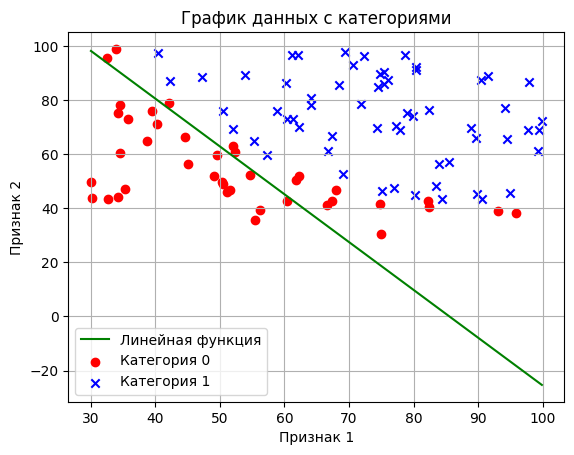

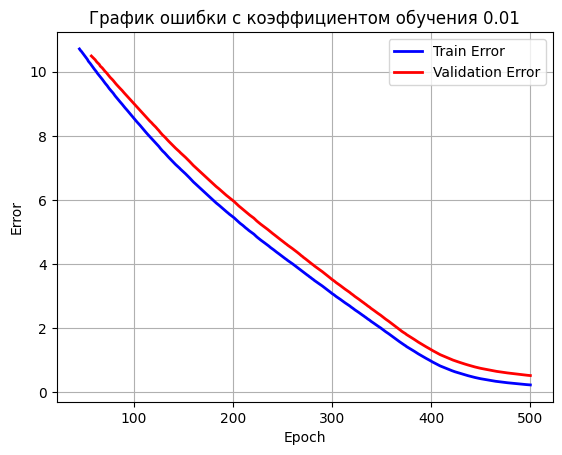

Train error: 0.2355978809132849 Validate error: 0.526734298608584
2.81138189905482


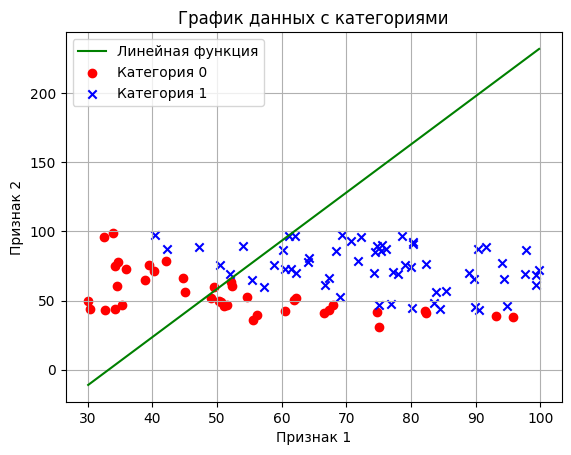

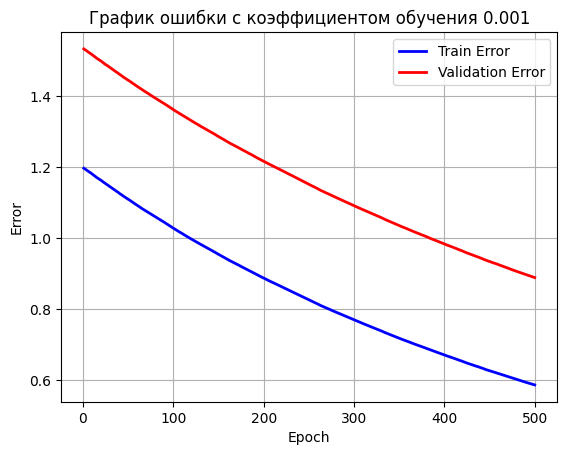

Train error: 0.5850108015116464 Validate error: 0.8880501707551005
-0.816219267642851


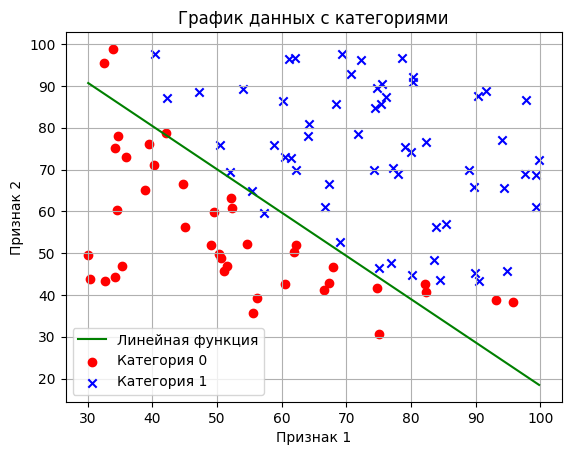

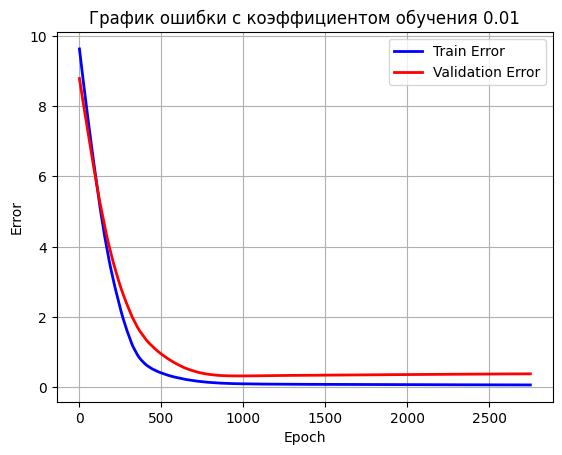

Train error: 0.06837546249215407 Validate error: 0.3840981421001407
0.267269123745717


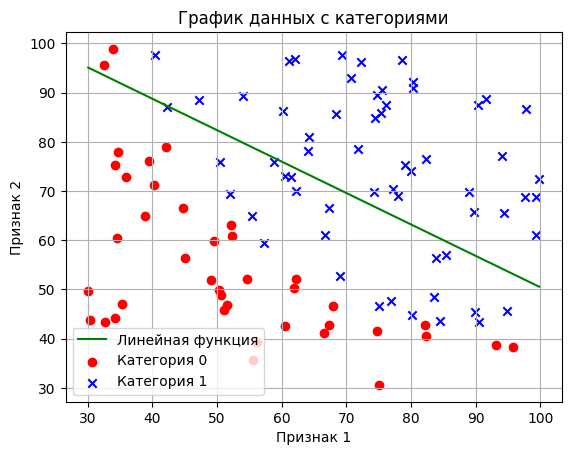

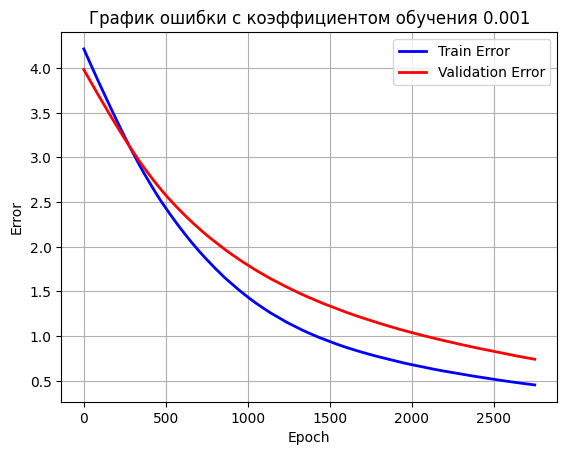

Train error: 0.45416066283827855 Validate error: 0.7418144578245215
-0.836886674093092


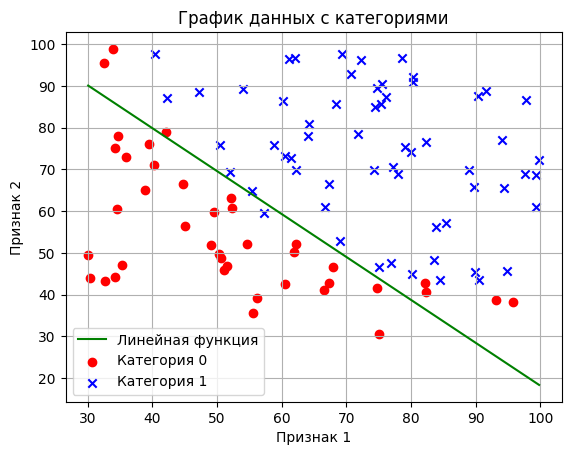

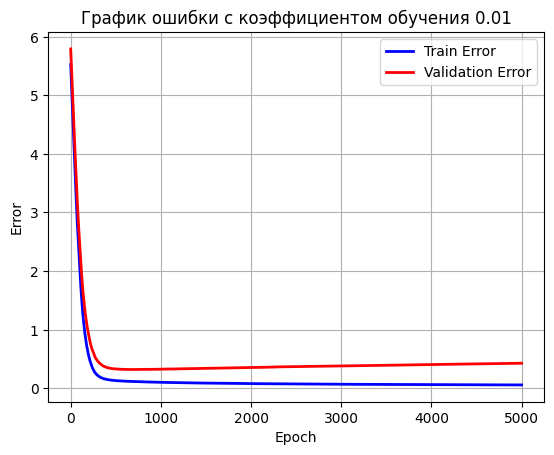

Train error: 0.057356737816278924 Validate error: 0.42741279308873126
-0.0100471729146424


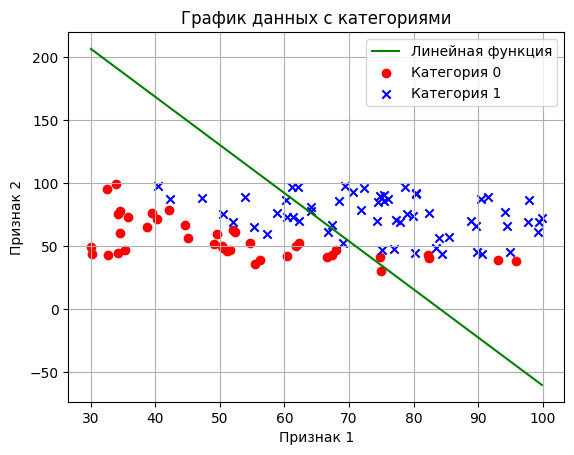

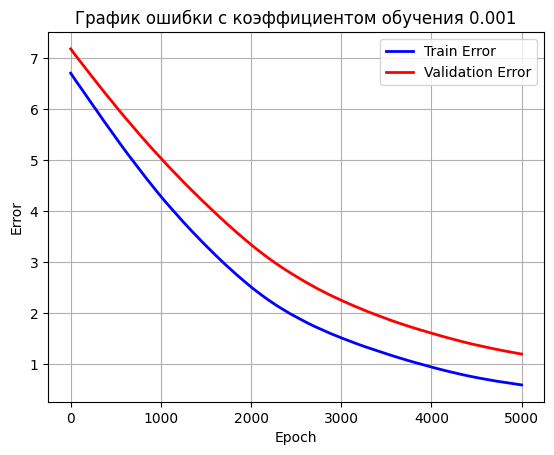

Train error: 0.5990261598954523 Validate error: 1.2036652962090784


In [7]:
X_train, y_train, X_validate, y_validate, means, stds = prepare_data(X, Y)

def calc1(t):
    x1, x2 = sp.symbols('x1 x2')
    expression = t[0] + t[1] * x1 + t[2] * x2
    expr = sp.solve(expression, x2)
    return x1,x2,expr

learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate, calc1)

Добавим столбцы с расчётными значениями:
* x1 ^2

-3.52706256539796


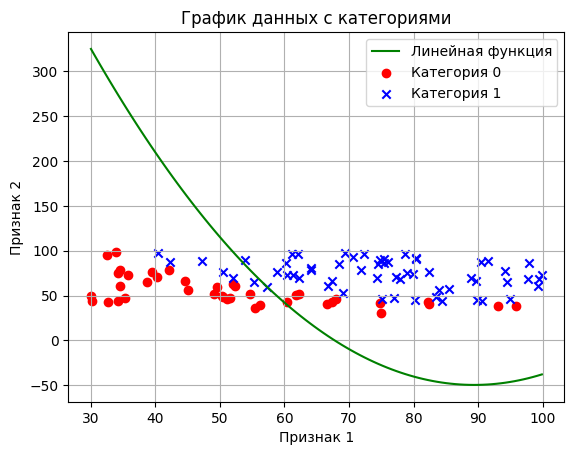

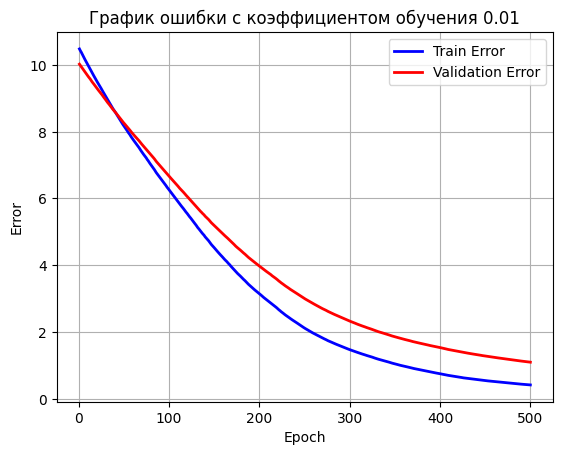

Train error: 0.4173109808722104 Validate error: 1.097905617674261
0.265658364752576


/tmp/ipykernel_19325/3360324562.py:65: RuntimeWarning: divide by zero encountered in log
  j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)


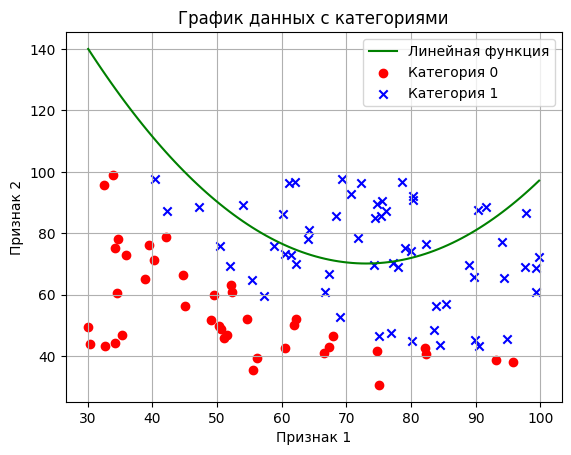

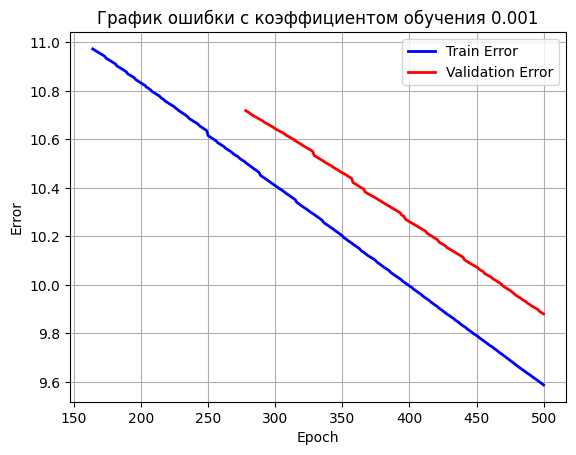

Train error: 9.586711963885095 Validate error: 9.87967233721915
-2.61538769656279


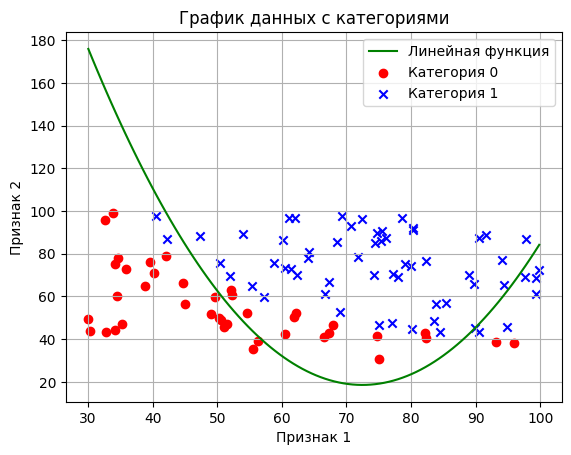

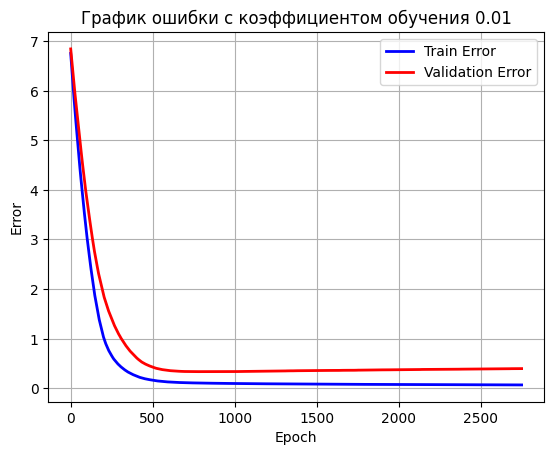

Train error: 0.06647140789350692 Validate error: 0.395245206850831
5.39835178540675


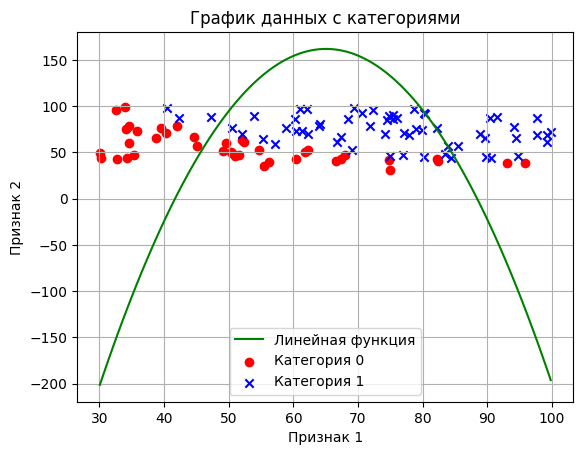

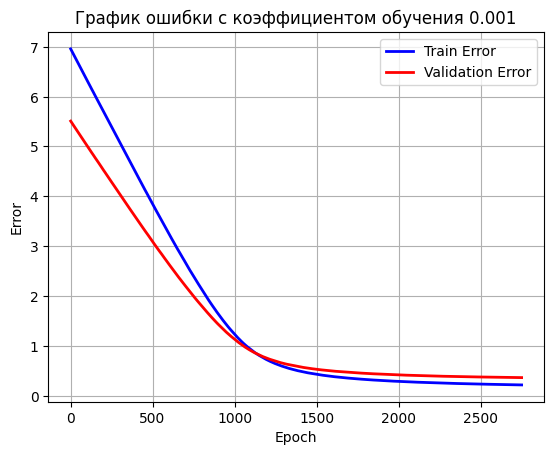

Train error: 0.21534283115353156 Validate error: 0.36225146639971767
0.324738918619701


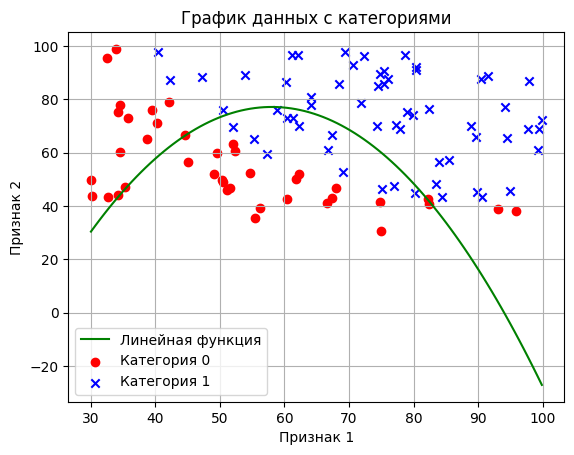

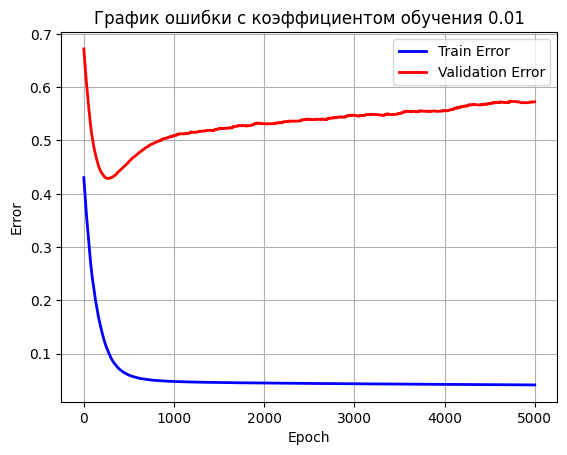

Train error: 0.04106764983779912 Validate error: 0.5721593007111894
0.541055439919291


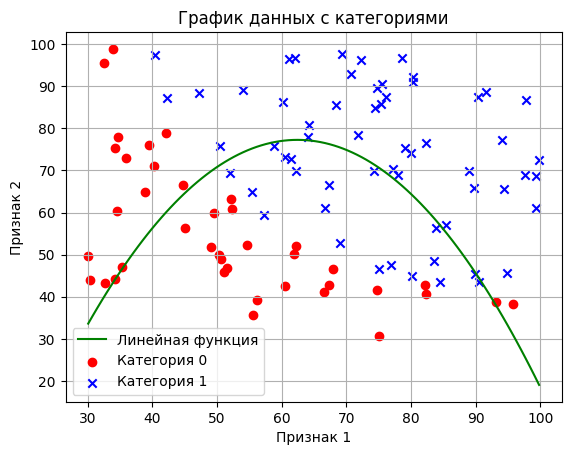

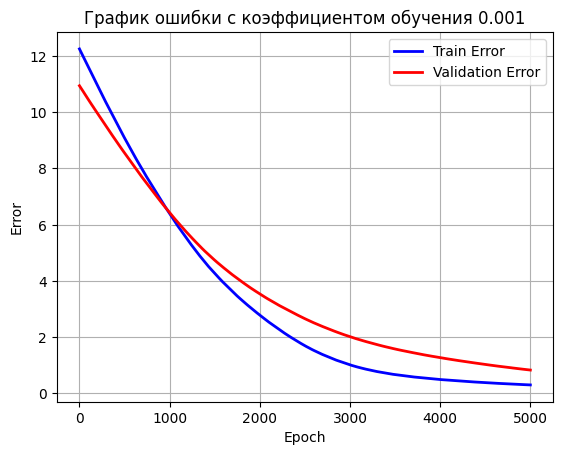

Train error: 0.29219194260555115 Validate error: 0.8219095449903959


In [8]:
X_train, y_train, X_validate, y_validate, means, stds = prepare_data(X, Y)

X_train = np.hstack((X_train, (X_train[:, 0] **2)[:, np.newaxis]))
X_validate = np.hstack((X_validate, (X_validate[:, 0] **2)[:, np.newaxis]))

def calc2(t):
    x1, x2 = sp.symbols('x1 x2')
    expression = t[0] + t[1] * x1 + t[2] * x2 + t[3] * (x1 ** 2)
    expr = sp.solve(expression, x2)
    return x1,x2,expr

learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate, calc2)